# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# import pyspark libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf, desc, approx_count_distinct, col, to_date \
                                  , from_unixtime, to_date, year, dayofyear, dayofweek, \
                                  dayofmonth, datediff, countDistinct, isnan
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.types import IntegerType, StringType

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, RegexTokenizer, CountVectorizer, HashingTF, IDF, VectorAssembler, \
                               Imputer
from pyspark.ml.classification import LinearSVC, LogisticRegression, BinaryLogisticRegressionSummary, \
                                      RandomForestClassifier, DecisionTreeClassifier, GBTClassifier, \
                                      NaiveBayes, MultilayerPerceptronClassifier

from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [3]:
# create a Spark session
spark = SparkSession.builder \
        .master("local")    \
        .appName("Sparkify Project") \
        .getOrCreate()


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [38]:
mini_sparkify = 'mini_sparkify_event_data.json'
df = spark.read.json(mini_sparkify)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [5]:
pd_df = df.sample(withReplacement=True, fraction=0.5).toPandas()[:10000]
pd_df.isnull().sum().sort_values()

userId              0
auth                0
ts                  0
status              0
itemInSession       0
sessionId           0
level               0
page                0
method              0
registration      321
location          321
lastName          321
gender            321
firstName         321
userAgent         321
length           2187
song             2187
artist           2187
dtype: int64

In [39]:
df = df.dropna(subset=['userId', 'sessionId', 'itemInSession', 'registration','location','lastName','gender','firstName','userAgent'])

In [40]:
imputer = Imputer(strategy='mean', inputCols=['length'], outputCols=['length'])

In [41]:
imputerModel = imputer.fit(df)

In [42]:
df = imputerModel.transform(df)

In [43]:
df = df.fillna({'song': 'unknown', 'artist': 'unknown'})

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [44]:
#Row number and column number
(df.count(),len(df.columns))

(278154, 18)

In [45]:
def create_churn(df=df, cancelled='Cancelled'):
    flag_churn_event = udf(lambda x: 1 if x == "Cancelled" else 0, IntegerType())
    df = df.withColumn(cancelled, flag_churn_event("auth"))
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    df = df.withColumn("Churn", Fsum(cancelled).over(windowval))
    return df

df = create_churn()

In [46]:
pd_df = df.sample(withReplacement=True, fraction=0.5).toPandas()[:10000]

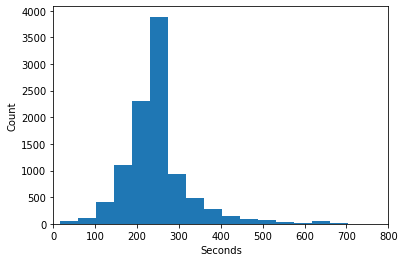

In [47]:
plt.hist(pd_df['length'].dropna(),bins=60);
plt.ylabel('Count');
plt.xlabel('Seconds');
plt.xlim(0,800);

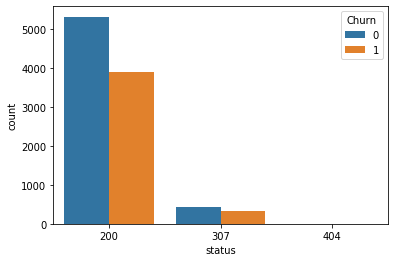

In [48]:
base_color = sns.color_palette()[0]
sns.countplot(data=pd_df, x='status',hue='Churn');
#plt.xlim(0,2000)

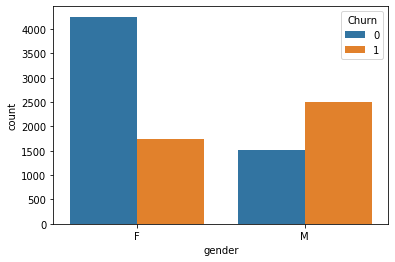

In [49]:
#Gender and Churn
sns.countplot(data=pd_df, x='gender', hue='Churn');

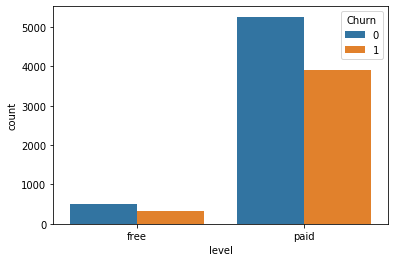

In [50]:
#Level and Churn
sns.countplot(data=pd_df, x='level', hue='Churn');

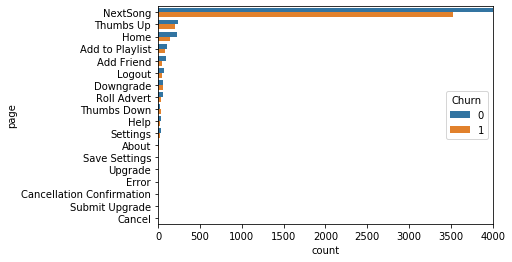

In [51]:
#Page and Churn
ordered_page = pd_df['page'].value_counts().index
sns.countplot(data=pd_df, y='page', order=ordered_page, hue='Churn');
plt.xlim(0,4000);

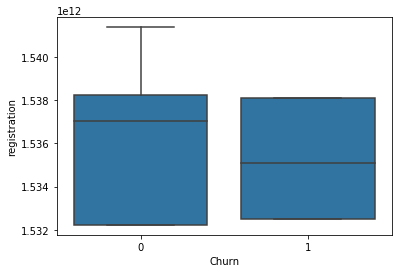

In [52]:
#Registration and Churn
sns.boxplot(data=pd_df, x='Churn',color=base_color, y='registration');

In [53]:
pd_agg_df = pd_df.groupby('userId').agg({'length':'mean', 'song': pd.Series.nunique,\
                                         'Churn':'max'})

In [54]:
#Total number of sample users
pd_agg_df.shape[0]

13

In [55]:
#Churn number of smaple users
pd_agg_df[pd_agg_df.Churn == 1].shape[0]

5

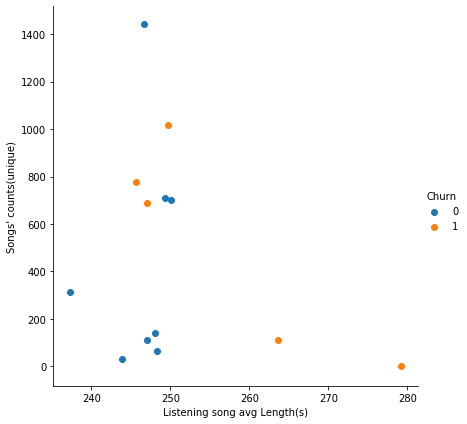

In [56]:
g = sns.FacetGrid(data=pd_agg_df,  hue='Churn', height=6);
g.map(plt.scatter, 'length', 'song');
plt.xlabel('Listening song avg Length(s)')
plt.ylabel("Songs' counts(unique)")
g.add_legend();

In [57]:
df.printSchema()

root
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- Churn: long (nullable = true)



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [58]:
#Turn the Churn column to label 
df = df.withColumn('label', col('Churn'))

In [59]:
fill_0_negative = udf(lambda x: 0 if x< 0 else x , IntegerType())
df = df.withColumn('registDays', fill_0_negative(datediff(to_date(from_unixtime(df['ts']/1000)), \
                                     to_date(from_unixtime(df['registration']/1000)))))

In [60]:
def create_paidRation(df=df):
    levelTotal_df = df.groupby(['userId']).count().withColumnRenamed('count', 'levelTotal')
    levelPaid_df = df[df.level=='paid'].groupby(['userId']).count().withColumnRenamed('count', 'levelPaid')
    df = df.join(levelTotal_df, on='userId', how='inner')
    df = df.join(levelPaid_df, on='userId', how='inner')
    df = df.withColumn('paidRatio',df['levelPaid']/df['levelTotal'])
    return df

In [61]:
df = create_paidRation(df)

In [62]:
def create_replayRatio(df=df):
    countDistinct_df = df.groupby(['userId']).agg(countDistinct('song').alias('countDistinctSongs'))
    agg_df = df.groupby(['userId']).agg({'length':'mean', 'song':'count'})
    df = df.join(countDistinct_df, on='userId', how='inner')
    df = df.join(agg_df, on='userId', how='inner')
    df = df.withColumnRenamed('count(song)', 'countSongs').withColumnRenamed('avg(length)', 'avgLength')
    df = df.withColumn('replayRatio', df['countSongs']/df['countDistinctSongs'])
    return df

In [63]:
df = create_replayRatio(df)

In [64]:
genderStringIndexer = StringIndexer(inputCol='gender', outputCol='genderIndexer', handleInvalid='skip')

In [65]:
levelStringIndexer = StringIndexer(inputCol='level', outputCol='levelIndexer', handleInvalid='skip')

In [66]:
vectAssembler = VectorAssembler(inputCols=['genderIndexer', 'registDays', \
                                           'levelIndexer', 'paidRatio', 'avgLength', \
                                           'countSongs', 'countDistinctSongs', \
                                           'replayRatio'], outputCol='features')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [67]:
train, test, validate = df.randomSplit([0.6, 0.2, 0.2], seed=42)


In [68]:
def build_model(train=train, test=test, pipeline= None, evaluator=None, paramGrid=None, numFolds=5):
    
    evaluator = evaluator
    crossvalid = CrossValidator(estimator=pipeline,
                                estimatorParamMaps=paramGrid,
                                evaluator=evaluator,
                                numFolds=numFolds)
    cvModel = crossvalid.fit(train)
    return cvModel
    

In [72]:
rfc = RandomForestClassifier()

pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer,vectAssembler, rfc])

paramGrid = ParamGridBuilder() \
            .addGrid(rfc.maxDepth, [2, 5, 10]) \
            .build()

evaluator = BinaryClassificationEvaluator()

cvModel = build_model(train, test, pipeline, evaluator, paramGrid)

print('areaUnderROC:{}'.format(evaluator.evaluate(cvModel.transform(test))))
print('areaUnderPR:{}'.format(evaluator.evaluate(cvModel.transform(test), {evaluator.metricName: "areaUnderPR"})))

areaUnderROC:0.9999494619233228
areaUnderPR:0.9997195317179808
cvModel attribute:{'uid': 'PipelineModel_e3889f0fb681', '_paramMap': {}, '_defaultParamMap': {}, '_params': None, 'stages': [StringIndexer_0ff63e630f8a, StringIndexer_10397e1f149d, VectorAssembler_589a59ebd558, RandomForestClassificationModel (uid=RandomForestClassifier_89b435859d46) with 20 trees]}


In [37]:
lsvc = LinearSVC()

pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer, vectAssembler, lsvc])

paramGrid = ParamGridBuilder() \
                .addGrid(lsvc.maxIter, [5, 10]) \
                .addGrid(lsvc.regParam, [0.0, 0.1]) \
                .build()
evaluator = BinaryClassificationEvaluator()

cvModel = build_model(train, test, pipeline, evaluator, paramGrid)

print('areaUnderROC:{}'.format(evaluator.evaluate(cvModel.transform(test))))
print('areaUnderPR:{}'.format(evaluator.evaluate(cvModel.transform(test), {evaluator.metricName: "areaUnderPR"})))
print('cvModel attribute:{}'.format(cvModel.bestModel.__dict__))

areaUnderROC:0.5961326754506855
areaUnderPR:0.21866613095689644


In [73]:
lr = LogisticRegression()

pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer,vectAssembler, lr])

paramGrid = ParamGridBuilder() \
            .addGrid(lr.maxIter, [5, 10]) \
            .addGrid(lr.regParam, [0.0, 0.1]) \
            .addGrid(lr.elasticNetParam, [0.0, 1.0]) \
            .build()

evaluator = BinaryClassificationEvaluator()

cvModel = build_model(train, test, pipeline, evaluator, paramGrid)

print('areaUnderROC:{}'.format(evaluator.evaluate(cvModel.transform(test))))
print('areaUnderPR:{}'.format(evaluator.evaluate(cvModel.transform(test), {evaluator.metricName: "areaUnderPR"})))
print('cvModel bestModel attribute:{}'.format(cvModel.bestModel.__dict__))

areaUnderROC:0.6895781745559943
areaUnderPR:0.281092516579012
cvModel bestModel attribute:{'uid': 'PipelineModel_14c922f6fe3d', '_paramMap': {}, '_defaultParamMap': {}, '_params': None, 'stages': [StringIndexer_0ff63e630f8a, StringIndexer_10397e1f149d, VectorAssembler_589a59ebd558, LogisticRegressionModel: uid = LogisticRegression_8661d62a5ceb, numClasses = 2, numFeatures = 8]}


In [38]:
dc = DecisionTreeClassifier()

pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer,vectAssembler, dc])

paramGrid = ParamGridBuilder() \
            .addGrid(dc.maxDepth, [2, 5]) \
            .addGrid(dc.maxBins, [32, 64]) \
            .build()

evaluator = BinaryClassificationEvaluator()

cvModel = build_model(train, test, pipeline, evaluator, paramGrid)

print('areaUnderROC:{}'.format(evaluator.evaluate(cvModel.transform(test))))
print('areaUnderPR:{}'.format(evaluator.evaluate(cvModel.transform(test), {evaluator.metricName: "areaUnderPR"})))

areaUnderROC:0.7040135368031165
areaUnderPR:0.23586776091066503


In [39]:
gbtc = GBTClassifier()

pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer,vectAssembler, gbtc])

paramGrid = ParamGridBuilder() \
            .addGrid(gbtc.maxIter, [5,10]) \
            .addGrid(gbtc.maxDepth, [2, 5]) \
            .addGrid(gbtc.maxBins, [32, 64]) \
            .build()

evaluator = BinaryClassificationEvaluator()

cvModel = build_model(train, test, pipeline, evaluator, paramGrid)

print('areaUnderROC:{}'.format(evaluator.evaluate(cvModel.transform(test))))
print('areaUnderPR:{}'.format(evaluator.evaluate(cvModel.transform(test), {evaluator.metricName: "areaUnderPR"})))
print('cvModel bestModel attribute:{}'.format(cvModel.bestModel.__dict__))


areaUnderROC:0.9998956462222165
areaUnderPR:0.9994413915610577
cvModel bestModel attribute:{'uid': 'PipelineModel_941f90812dc1', '_paramMap': {}, '_defaultParamMap': {}, '_params': None, 'stages': [StringIndexer_127f93bb1059, StringIndexer_3672e7f26df6, VectorAssembler_a1a0cbc8500b, GBTClassificationModel (uid=GBTClassifier_aec9f7f3d82e) with 10 trees]}


In [69]:
nb = NaiveBayes()

pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer,vectAssembler, nb])

paramGrid = ParamGridBuilder()                                                                              \
            .addGrid(nb.smoothing, [0.1, 0.5])                                                              \
            .build()

evaluator = BinaryClassificationEvaluator()

cvModel = build_model(train, test, pipeline, evaluator, paramGrid)

print('areaUnderROC:{}'.format(evaluator.evaluate(cvModel.transform(test))))
print('areaUnderPR:{}'.format(evaluator.evaluate(cvModel.transform(test), {evaluator.metricName: "areaUnderPR"})))

areaUnderROC:0.666748002095109
areaUnderPR:0.2609827419234653


In [70]:
mpc = MultilayerPerceptronClassifier(layers=[8, 15, 10, 2])

pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer,vectAssembler, mpc])

# .addGrid(mpc.stepSize, [0.01, 0.03]) \
paramGrid = ParamGridBuilder() \
            .addGrid(mpc.maxIter, [5,10]) \
            .addGrid(mpc.blockSize, [10, 100]) \
            .build()

evaluator = BinaryClassificationEvaluator()

cvModel = build_model(train, test, pipeline, evaluator, paramGrid)

print('areaUnderROC:{}'.format(evaluator.evaluate(cvModel.transform(test))))
print('areaUnderPR:{}'.format(evaluator.evaluate(cvModel.transform(test), {evaluator.metricName: "areaUnderPR"})))

areaUnderROC:0.6227002591037091
areaUnderPR:0.22845145780872422


### Final Model Selection

Gradient Boosting seems to do comparatively for this case

In [74]:
rfc = RandomForestClassifier()

pipeline = Pipeline(stages=[genderStringIndexer, levelStringIndexer,vectAssembler, rfc])

paramGrid = ParamGridBuilder() \
            .addGrid(rfc.maxDepth, [2, 5, 10]) \
            .addGrid(rfc.maxBins, [8, 32]) \
            .addGrid(rfc.numTrees, [10, 20]) \
            .build()

evaluator = BinaryClassificationEvaluator()

cvModel = build_model(train, test, pipeline, evaluator, paramGrid)

print('areaUnderPR:{}'.format(evaluator.evaluate(cvModel.transform(validate), {evaluator.metricName: "areaUnderPR"})))

areaUnderPR:1.0


In [76]:
prediction = cvModel.transform(test)

In [77]:
prediction.printSchema()

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = false)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = false)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- Cancelled: integer (nullable = true)
 |-- Churn: long (nullable = true)
 |-- label: long (nullable = true)
 |-- registDays: integer (nullable = true)
 |-- levelTotal: long (nullable = false)
 |-- levelPaid: long (nullable = false)
 |-- paidRatio: double (nullable = true)
 |-- countDistinctSongs: lo

In [82]:
prediction.select('userId','label','prediction').dropDuplicates().show()

+------+-----+----------+
|userId|label|prediction|
+------+-----+----------+
|200002|    0|       0.0|
|   124|    0|       0.0|
|    51|    1|       1.0|
|    15|    0|       0.0|
|    54|    1|       1.0|
|   155|    0|       0.0|
|100014|    1|       1.0|
|   132|    0|       0.0|
|   101|    1|       1.0|
|    11|    0|       0.0|
|   138|    0|       0.0|
|300017|    0|       0.0|
|    29|    1|       1.0|
|    69|    0|       0.0|
|    42|    0|       0.0|
|    73|    1|       1.0|
|    87|    1|       1.0|
|     3|    1|       1.0|
|   113|    0|       0.0|
|    30|    0|       0.0|
+------+-----+----------+
only showing top 20 rows



### Conclusion

Feature Engineering is most time killing and most creative part.Exploratory a useful feature is difficult.


### Improvement

Exploratorying more Features, the implementation mybe being improved. 


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.